In [ ]:
import torch

/content/drive/MyDrive/lazimpa


In [ ]:
!ls

acc_evol_dys2.png			  dir_save_dys1
analysis				  dir_save_dys2
analysis_dys1				  egg
analysis_dys2				  length_evol_dys2.png
avg_position_informative_symbol_dys2.png  message_length_by_frequency_dys2.png
dir_save				  position_informative_symbols_dys2.png


In [ ]:
# Copyright (c) Facebook, Inc. and its affiliates.

# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

import json
import argparse
import numpy as np
import torch.utils.data
import torch.nn.functional as F
import egg.core as core
from egg.core import EarlyStopperAccuracy
from egg.zoo.channel.features import OneHotLoader, UniformLoader
from egg.zoo.channel.archs import Sender, Receiver
from egg.core.reinforce_wrappers import RnnReceiverImpatient
from egg.core.reinforce_wrappers import SenderImpatientReceiverRnnReinforce
from egg.core.util_dyslexia import dump_sender_receiver_impatient # util => util_dyslexia ####ATTENTION RECHANGER !!!

def get_params(params):
    parser = argparse.ArgumentParser()
    parser.add_argument('--n_features', type=int, default=10,
                        help='Dimensionality of the "concept" space (default: 10)')
    parser.add_argument('--batches_per_epoch', type=int, default=1000,
                        help='Number of batches per epoch (default: 1000)')
    parser.add_argument('--dim_dataset', type=int, default=10240,
                        help='Dim of constructing the data (default: 10240)')
    parser.add_argument('--force_eos', type=int, default=0,
                        help='Force EOS at the end of the messages (default: 0)')

    parser.add_argument('--sender_hidden', type=int, default=10,
                        help='Size of the hidden layer of Sender (default: 10)')
    parser.add_argument('--receiver_hidden', type=int, default=10,
                        help='Size of the hidden layer of Receiver (default: 10)')
    parser.add_argument('--receiver_num_layers', type=int, default=1,
                        help='Number hidden layers of receiver. Only in reinforce (default: 1)')
    parser.add_argument('--sender_num_layers', type=int, default=1,
                        help='Number hidden layers of receiver. Only in reinforce (default: 1)')
    parser.add_argument('--receiver_num_heads', type=int, default=8,
                        help='Number of attention heads for Transformer Receiver (default: 8)')
    parser.add_argument('--sender_num_heads', type=int, default=8,
                        help='Number of self-attention heads for Transformer Sender (default: 8)')
    parser.add_argument('--sender_embedding', type=int, default=10,
                        help='Dimensionality of the embedding hidden layer for Sender (default: 10)')
    parser.add_argument('--receiver_embedding', type=int, default=10,
                        help='Dimensionality of the embedding hidden layer for Receiver (default: 10)')

    parser.add_argument('--causal_sender', default=False, action='store_true')
    parser.add_argument('--causal_receiver', default=False, action='store_true')

    parser.add_argument('--sender_generate_style', type=str, default='in-place', choices=['standard', 'in-place'],
                        help='How the next symbol is generated within the TransformerDecoder (default: in-place)')

    parser.add_argument('--sender_cell', type=str, default='rnn',
                        help='Type of the cell used for Sender {rnn, gru, lstm, transformer} (default: rnn)')
    parser.add_argument('--receiver_cell', type=str, default='rnn',
                        help='Type of the model used for Receiver {rnn, gru, lstm, transformer} (default: rnn)')

    parser.add_argument('--sender_entropy_coeff', type=float, default=1e-1,
                        help='The entropy regularisation coefficient for Sender (default: 1e-1)')
    parser.add_argument('--receiver_entropy_coeff', type=float, default=1e-1,
                        help='The entropy regularisation coefficient for Receiver (default: 1e-1)')

    parser.add_argument('--probs', type=str, default='uniform',
                        help="Prior distribution over the concepts (default: uniform)")
    parser.add_argument('--length_cost', type=float, default=0.0,
                        help="Penalty for the message length, each symbol would before <EOS> would be "
                             "penalized by this cost (default: 0.0)")
    parser.add_argument('--name', type=str, default='model',
                        help="Name for your checkpoint (default: model)")
    parser.add_argument('--early_stopping_thr', type=float, default=0.9999,
                        help="Early stopping threshold on accuracy (default: 0.9999)")

    # AJOUT
    parser.add_argument('--dir_save', type=str, default="expe_1",
                        help="Directory in which we will save the information")
    parser.add_argument('--unigram_pen', type=float, default=0.0,
                        help="Add a penalty for redundancy")
    parser.add_argument('--impatient', type=bool, default=False,
                        help="Impatient listener")
    parser.add_argument('--print_message', type=bool, default=False,
                        help='Print message ?')
    parser.add_argument('--reg', type=bool, default=False,
                        help='Add regularization ?')

    args = core.init(parser, params)

    return args


def loss(sender_input, _message, _receiver_input, receiver_output, _labels):
    acc = (receiver_output.argmax(dim=1) == sender_input.argmax(dim=1)).detach().float()
    loss = F.cross_entropy(receiver_output, sender_input.argmax(dim=1), reduction="none")
    return loss, {'acc': acc}

def loss_impatient(sender_input, _message, message_length, _receiver_input, receiver_output, _labels):

    """
    Compute the loss function for the Impatient Listener.
    It is equal to the average cross entropy of all the intermediate predictions

    Params:
    - sender_input: ground truth 1-hot vector | size=(batch_size,n_features)
    - receiver_output: receiver predictions | size=(batch_size,max_len,n_features)
    - message_lengh: message length | size=(batch_size)

    Returns:
    - loss: |  size= ????
    - {acc:acc}: mean accuracy | size=(batch_size)
    - crible_acc: accuracy by position | size=(batch_size,max_len)
    """

    # 1. len_mask selects only the symbols before EOS-token
    to_onehot=torch.eye(_message.size(1)).to("cuda")
    to_onehot=torch.cat((to_onehot,torch.zeros((1,_message.size(1))).to("cuda")),0)
    len_mask=[]
    for i in range(message_length.size(0)):
      len_mask.append(to_onehot[message_length[i]])
    len_mask=torch.stack(len_mask,dim=0)

    len_mask=torch.cumsum(len_mask,dim=1)
    len_mask=torch.ones(len_mask.size()).to("cuda").add_(-len_mask)

    # 2. coef applies weights on each position. By default it is equal
    coef=(1/message_length.to(float)).repeat(_message.size(1),1).transpose(1,0) # useless ?
    coef2=coef # useless ?
    len_mask.mul_((coef2)) # useless ?
    len_mask.mul_((1/len_mask.sum(1)).repeat((_message.size(1),1)).transpose(1,0))

    # Test: change positional wieghts
    #coef2=coef*torch.arange(_message.size(1),0,-1).repeat(_message.size(0),1).to("cuda")


    # 3. crible_acc gathers accuracy for each input/position, crible_loss gathers losses for each input/position
    crible_acc=torch.zeros(size=_message.size()).to("cuda")
    crible_loss=torch.zeros(size=_message.size()).to("cuda")

    for i in range(receiver_output.size(1)):
      crible_acc[:,i].add_((receiver_output[:,i,:].argmax(dim=1) == sender_input.argmax(dim=1)).detach().float())
      crible_loss[:,i].add_(F.cross_entropy(receiver_output[:,i,:], sender_input.argmax(dim=1), reduction="none"))

    # 4. Apply mask to remove the positions after EOS-token
    acc=crible_acc*len_mask
    loss=crible_loss*len_mask

    acc = acc.sum(1)
    loss= loss.sum(1)

    return loss, {'acc': acc}, crible_acc

#def loss_impatient2(sender_input, _message, message_length, _receiver_input, receiver_output, _labels):

#    to_onehot=torch.eye(_message.size(1)).to("cuda")
#    to_onehot=torch.cat((to_onehot,torch.zeros((1,_message.size(1))).to("cuda")),0)
#    len_mask=[]
#    len_mask2=[]
#    for i in range(message_length.size(0)):
#      len_mask.append(to_onehot[message_length[i]])
#      len_mask2.append(to_onehot[message_length[i]-1])
#    len_mask=torch.stack(len_mask,dim=0)
#    len_mask2=torch.stack(len_mask2,dim=0)

#    coef=(1/message_length.to(float)).repeat(_message.size(1),1).transpose(1,0)
#    coef2=coef*torch.arange(_message.size(1),0,-1).repeat(_message.size(0),1).to("cuda")

#    len_mask=torch.cumsum(len_mask,dim=1)
#    len_mask=torch.ones(len_mask.size()).to("cuda").add_(-len_mask)

#    len_mask.mul_((coef2))
#    len_mask.mul_((1/len_mask.sum(1)).repeat((_message.size(1),1)).transpose(1,0))

#    crible_acc=torch.zeros(size=_message.size()).to("cuda")
#    crible_loss=torch.zeros(size=_message.size()).to("cuda")

#    for i in range(receiver_output.size(1)):
#      crible_acc[:,i].add_((receiver_output[:,i,:].argmax(dim=1) == sender_input.argmax(dim=1)).detach().float())
#      crible_loss[:,i].add_(F.cross_entropy(receiver_output[:,i,:], sender_input.argmax(dim=1), reduction="none"))

#    acc=crible_acc*len_mask
#    loss=crible_loss*len_mask

#    acc2=crible_acc*len_mask2
#    loss2=crible_loss*len_mask2
#    loss2=torch.cumsum(loss2,dim=1)
#    acc2=torch.cumsum(acc2,dim=1)

#    loss.add_(loss2)
#    acc.add_(acc2)

    # Moyenne
#    loss.mul_(torch.ones(len_mask.size()).to("cuda")*(1/crible_loss.size(1)))
#    acc.mul_(torch.ones(len_mask.size()).to("cuda")*(1/crible_loss.size(1)))

#    acc = acc.sum(1)
#    loss= loss.sum(1)

#    return loss, {'acc': acc}, crible_acc

def dump(game, n_features, device, gs_mode, epoch):
    # tiny "dataset"
    dataset = [[torch.eye(n_features).to(device), None]]

    sender_inputs, messages, receiver_inputs, receiver_outputs, _ = \
        core.dump_sender_receiver(game, dataset, gs=gs_mode, device=device, variable_length=True)

    unif_acc = 0.
    powerlaw_acc = 0.
    powerlaw_probs = 1 / np.arange(1, n_features+1, dtype=np.float32)
    powerlaw_probs /= powerlaw_probs.sum()

    acc_vec=np.zeros(n_features)

    for sender_input, message, receiver_output in zip(sender_inputs, messages, receiver_outputs):
        input_symbol = sender_input.argmax()
        output_symbol = receiver_output.argmax()
        acc = (input_symbol == output_symbol).float().item()

        acc_vec[int(input_symbol)]=acc

        unif_acc += acc
        powerlaw_acc += powerlaw_probs[input_symbol] * acc
        if epoch%50==0:
            print(f'input: {input_symbol.item()} -> message: {",".join([str(x.item()) for x in message])} -> output: {output_symbol.item()}', flush=True)

    unif_acc /= n_features

    #print(f'Mean accuracy wrt uniform distribution is {unif_acc}')
    #print(f'Mean accuracy wrt powerlaw distribution is {powerlaw_acc}')
    print(json.dumps({'powerlaw': powerlaw_acc, 'unif': unif_acc}))

    return acc_vec, messages

def dump_impatient(game, n_features, device, gs_mode,epoch):
    # tiny "dataset"
    dataset = [[torch.eye(n_features).to(device), None]]

    sender_inputs, messages, receiver_inputs, receiver_outputs, _ = \
        dump_sender_receiver_impatient(game, dataset, gs=gs_mode, device=device, variable_length=True)

    unif_acc = 0.
    powerlaw_acc = 0.
    powerlaw_probs = 1 / np.arange(1, n_features+1, dtype=np.float32)
    powerlaw_probs /= powerlaw_probs.sum()

    acc_vec=np.zeros(n_features)

    for sender_input, message, receiver_output in zip(sender_inputs, messages, receiver_outputs):
        input_symbol = sender_input.argmax()
        output_symbol = receiver_output.argmax()
        acc = (input_symbol == output_symbol).float().item()

        acc_vec[int(input_symbol)]=acc

        unif_acc += acc
        powerlaw_acc += powerlaw_probs[input_symbol] * acc
        if epoch%100==0:
            print(f'input: {input_symbol.item()} -> message: {",".join([str(x.item()) for x in message])} -> output: {output_symbol.item()}', flush=True)

    unif_acc /= n_features

    #print(f'Mean accuracy wrt uniform distribution is {unif_acc}')
    #print(f'Mean accuracy wrt powerlaw distribution is {powerlaw_acc}')
    if epoch%25==0:
        print(json.dumps({'powerlaw': powerlaw_acc, 'unif': unif_acc}))

    return acc_vec, messages

def main(params):
    print(torch.cuda.is_available())
    opts = get_params(params)
    print(opts, flush=True)
    device = opts.device

    force_eos = opts.force_eos == 1

    if opts.probs == 'uniform':
        probs = np.ones(opts.n_features)
    elif opts.probs == 'powerlaw':
        probs = 1 / np.arange(1, opts.n_features+1, dtype=np.float32)
    #elif opts.probs == "creneau":
    #    ones = np.ones(int(opts.n_features/2))
    #    tens = 10*np.ones(opts.n_features-int(opts.n_features/2))
    #    probs = np.concatenate((tens,ones),axis=0)
    #elif opts.probs == "toy":
    #    fives = 5*np.ones(int(opts.n_features/10))
    #    ones = np.ones(opts.n_features-int(opts.n_features/10))
    #    probs = np.concatenate((fives,ones),axis=0)
    #elif opts.probs == "escalier":
    #    ones = np.ones(int(opts.n_features/4))
    #    tens = 10*np.ones(int(opts.n_features/4))
    #    huns = 100*np.ones(int(opts.n_features/4))
    #    thous = 1000*np.ones(opts.n_features-3*int(opts.n_features/4))
    #    probs = np.concatenate((thous,huns,tens,ones),axis=0)
    else:
        probs = np.array([float(x) for x in opts.probs.split(',')], dtype=np.float32)

    probs /= probs.sum()

    print('the probs are: ', probs, flush=True)

    train_loader = OneHotLoader(n_features=opts.n_features, batch_size=opts.batch_size,
                                batches_per_epoch=opts.batches_per_epoch, probs=probs)

    # single batches with 1s on the diag
    test_loader = UniformLoader(opts.n_features)

    if opts.sender_cell == 'transformer':
        sender = Sender(n_features=opts.n_features, n_hidden=opts.sender_embedding)
        sender = core.TransformerSenderReinforce(agent=sender, vocab_size=opts.vocab_size,
                                                 embed_dim=opts.sender_embedding, max_len=opts.max_len,
                                                 num_layers=opts.sender_num_layers, num_heads=opts.sender_num_heads,
                                                 hidden_size=opts.sender_hidden,
                                                 force_eos=opts.force_eos,
                                                 generate_style=opts.sender_generate_style,
                                                 causal=opts.causal_sender)
    else:
        sender = Sender(n_features=opts.n_features, n_hidden=opts.sender_hidden)

        sender = core.RnnSenderReinforce(sender,
                                   opts.vocab_size, opts.sender_embedding, opts.sender_hidden,
                                   cell=opts.sender_cell, max_len=opts.max_len, num_layers=opts.sender_num_layers,
                                   force_eos=force_eos)
    if opts.receiver_cell == 'transformer':
        receiver = Receiver(n_features=opts.n_features, n_hidden=opts.receiver_embedding)
        receiver = core.TransformerReceiverDeterministic(receiver, opts.vocab_size, opts.max_len,
                                                         opts.receiver_embedding, opts.receiver_num_heads, opts.receiver_hidden,
                                                         opts.receiver_num_layers, causal=opts.causal_receiver)
    else:

        receiver = Receiver(n_features=opts.n_features, n_hidden=opts.receiver_hidden)

        if not opts.impatient:
          receiver = Receiver(n_features=opts.n_features, n_hidden=opts.receiver_hidden)
          receiver = core.RnnReceiverDeterministic(receiver, opts.vocab_size, opts.receiver_embedding,
                                                 opts.receiver_hidden, cell=opts.receiver_cell,
                                                 num_layers=opts.receiver_num_layers)
        else:
          receiver = Receiver(n_features=opts.receiver_hidden, n_hidden=opts.vocab_size)
          # If impatient 1
          receiver = RnnReceiverImpatient(receiver, opts.vocab_size, opts.receiver_embedding,
                                            opts.receiver_hidden, cell=opts.receiver_cell,
                                            num_layers=opts.receiver_num_layers, max_len=opts.max_len, n_features=opts.n_features)
          # If impatient 2
          #receiver = RnnReceiverImpatient2(receiver, opts.vocab_size, opts.receiver_embedding,
        #                                         opts.receiver_hidden, cell=opts.receiver_cell,
        #                                         num_layers=opts.receiver_num_layers, max_len=opts.max_len, n_features=opts.n_features)

    #sender.load_state_dict(torch.load('dir_save_dys1/sender/sender_weights300.pth',map_location=torch.device('cpu')))
    #receiver.load_state_dict(torch.load('dir_save_dys1/receiver/receiver_weights300.pth',map_location=torch.device('cpu')))

    if not opts.impatient:
        game = core.SenderReceiverRnnReinforce(sender, receiver, loss, sender_entropy_coeff=opts.sender_entropy_coeff,
                                           receiver_entropy_coeff=opts.receiver_entropy_coeff,
                                           length_cost=opts.length_cost,unigram_penalty=opts.unigram_pen,reg=opts.reg)
    else:
        game = SenderImpatientReceiverRnnReinforce(sender, receiver, loss_impatient, sender_entropy_coeff=opts.sender_entropy_coeff,
                                           receiver_entropy_coeff=opts.receiver_entropy_coeff,
                                           length_cost=opts.length_cost,unigram_penalty=opts.unigram_pen,reg=opts.reg)

    optimizer = core.build_optimizer(game.parameters())

    trainer = core.Trainer(game=game, optimizer=optimizer, train_data=train_loader,
                           validation_data=test_loader, callbacks=[EarlyStopperAccuracy(opts.early_stopping_thr)])




    for epoch in range(int(opts.n_epochs)):

        print("Epoch: "+str(epoch))

        if epoch%100==0:
          trainer.optimizer.defaults["lr"]/=2

        trainer.train(n_epochs=1)
        if opts.checkpoint_dir:
            trainer.save_checkpoint(name=f'{opts.name}_vocab{opts.vocab_size}_rs{opts.random_seed}_lr{opts.lr}_shid{opts.sender_hidden}_rhid{opts.receiver_hidden}_sentr{opts.sender_entropy_coeff}_reg{opts.length_cost}_max_len{opts.max_len}')

        if not opts.impatient:
            acc_vec,messages=dump(trainer.game, opts.n_features, device, False,epoch)
        else:
            acc_vec,messages=dump_impatient(trainer.game, opts.n_features, device, False,epoch)

        # ADDITION TO SAVE MESSAGES
        all_messages=[]
        for x in messages:
            x = x.cpu().numpy()
            all_messages.append(x)
        all_messages = np.asarray(all_messages)

        if epoch%50==0:
            torch.save(sender.state_dict(), opts.dir_save+"/sender/sender_weights"+str(epoch)+".pth")
            torch.save(receiver.state_dict(), opts.dir_save+"/receiver/receiver_weights"+str(epoch)+".pth")
            print(acc_vec)

        np.save(opts.dir_save+'/messages/messages_'+str((epoch))+'.npy', all_messages)
        np.save(opts.dir_save+'/accuracy/accuracy_'+str((epoch))+'.npy', acc_vec)

    core.close()


if __name__ == "__main__":
    import sys
    main(['--dir_save=dir_save', '--vocab_size=40', '--max_len=30', '--impatient=True', '--reg=True', '--n_features=100', '--print_message=False', '--random_seed=7',
          '--probs=powerlaw', '--n_epoch=801', '--batch_size=512', '--length_cost=0.', '--sender_cell=lstm',  '--receiver_cell=lstm', '--sender_hidden=250',
          '--receiver_hidden=600', '--receiver_embedding=100', '--sender_embedding=10', '--batches_per_epoch=100', '--lr=0.001', '--sender_entropy_coeff=2.',
          '--sender_num_layers=1', '--receiver_num_layers=1', '--early_stopping_thr=0.99'])


True
Namespace(batch_size=512, batches_per_epoch=100, causal_receiver=False, causal_sender=False, checkpoint_dir=None, checkpoint_freq=0, cuda=True, device='cuda', dim_dataset=10240, dir_save='dir_save', early_stopping_thr=0.99, force_eos=0, impatient=True, length_cost=0.0, load_from_checkpoint=None, lr=0.001, max_len=30, n_epochs=801, n_features=100, name='model', no_cuda=False, optimizer='adam', preemptable=False, print_message=True, probs='powerlaw', random_seed=7, receiver_cell='lstm', receiver_embedding=100, receiver_entropy_coeff=0.1, receiver_hidden=600, receiver_num_heads=8, receiver_num_layers=1, reg=True, sender_cell='lstm', sender_embedding=10, sender_entropy_coeff=2.0, sender_generate_style='in-place', sender_hidden=250, sender_num_heads=8, sender_num_layers=1, tensorboard=False, tensorboard_dir='runs/', unigram_pen=0.0, validation_freq=1, vocab_size=40)
the probs are:  [0.1927756  0.0963878  0.06425854 0.0481939  0.03855512 0.03212927
 0.02753937 0.02409695 0.02141951 0.01

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:386: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch: 4
Impatient score=30
Epoch: 5
Impatient score=11
Epoch: 6
Impatient score=30
Epoch: 7
Impatient score=30
Epoch: 8
Impatient score=30
Epoch: 9
Impatient score=30
Epoch: 10
Impatient score=30
Epoch: 11
Impatient score=30
Epoch: 12
Impatient score=31
Epoch: 13
Impatient score=31
Epoch: 14
Impatient score=34
Epoch: 15
Impatient score=61
Epoch: 16
Impatient score=177
Epoch: 17
Impatient score=199
Epoch: 18
Impatient score=279
Epoch: 19
Impatient score=338
Epoch: 20
Impatient score=285
Epoch: 21
Impatient score=296
Epoch: 22
Impatient score=375
Epoch: 23
Impatient score=535
Epoch: 24
Impatient score=482
Epoch: 25
Impatient score=656
{"powerlaw": 0.6298887124285102, "unif": 0.23}
Epoch: 26
Impatient score=610
Epoch: 27
Impatient score=623
Epoch: 28
Impatient score=728
Epoch: 29
Impatient score=628
Epoch: 30
Impatient score=690
Epoch: 31
Impatient score=578
Epoch: 32
Impatient score=862
Epoch: 33
Impatient score=744
Epoch: 34
Impatient score=875
Epoch: 35
Impatient score=956
Epoch: 36
I

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Apr 11 14:05:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Copyright (c) Facebook, Inc. and its affiliates.

# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

import json
import argparse
import numpy as np
import torch.utils.data
import torch.nn.functional as F
import egg.core as core
from egg.core import EarlyStopperAccuracy
from egg.zoo.channel.features import OneHotLoader, UniformLoader
from egg.zoo.channel.archs import Sender, Receiver
from egg.core.util import dump_sender_receiver_test
from egg.core.util import dump_impose_message
from egg.core.reinforce_wrappers import RnnReceiverImpatient
from egg.core.reinforce_wrappers import SenderImpatientReceiverRnnReinforce
from egg.core.util import dump_sender_receiver_impatient


def get_params(params):
    parser = argparse.ArgumentParser()
    parser.add_argument('--n_features', type=int, default=10,
                        help='Dimensionality of the "concept" space (default: 10)')
    parser.add_argument('--batches_per_epoch', type=int, default=1000,
                        help='Number of batches per epoch (default: 1000)')
    parser.add_argument('--dim_dataset', type=int, default=10240,
                        help='Dim of constructing the data (default: 10240)')
    parser.add_argument('--force_eos', type=int, default=0,
                        help='Force EOS at the end of the messages (default: 0)')

    parser.add_argument('--sender_hidden', type=int, default=10,
                        help='Size of the hidden layer of Sender (default: 10)')
    parser.add_argument('--receiver_hidden', type=int, default=10,
                        help='Size of the hidden layer of Receiver (default: 10)')
    parser.add_argument('--receiver_num_layers', type=int, default=1,
                        help='Number hidden layers of receiver. Only in reinforce (default: 1)')
    parser.add_argument('--sender_num_layers', type=int, default=1,
                        help='Number hidden layers of receiver. Only in reinforce (default: 1)')
    parser.add_argument('--receiver_num_heads', type=int, default=8,
                        help='Number of attention heads for Transformer Receiver (default: 8)')
    parser.add_argument('--sender_num_heads', type=int, default=8,
                        help='Number of self-attention heads for Transformer Sender (default: 8)')
    parser.add_argument('--sender_embedding', type=int, default=10,
                        help='Dimensionality of the embedding hidden layer for Sender (default: 10)')
    parser.add_argument('--receiver_embedding', type=int, default=10,
                        help='Dimensionality of the embedding hidden layer for Receiver (default: 10)')

    parser.add_argument('--causal_sender', default=False, action='store_true')
    parser.add_argument('--causal_receiver', default=False, action='store_true')

    parser.add_argument('--sender_generate_style', type=str, default='in-place', choices=['standard', 'in-place'],
                        help='How the next symbol is generated within the TransformerDecoder (default: in-place)')

    parser.add_argument('--sender_cell', type=str, default='rnn',
                        help='Type of the cell used for Sender {rnn, gru, lstm, transformer} (default: rnn)')
    parser.add_argument('--receiver_cell', type=str, default='rnn',
                        help='Type of the model used for Receiver {rnn, gru, lstm, transformer} (default: rnn)')

    parser.add_argument('--sender_entropy_coeff', type=float, default=1e-1,
                        help='The entropy regularisation coefficient for Sender (default: 1e-1)')
    parser.add_argument('--receiver_entropy_coeff', type=float, default=1e-1,
                        help='The entropy regularisation coefficient for Receiver (default: 1e-1)')

    parser.add_argument('--probs', type=str, default='uniform',
                        help="Prior distribution over the concepts (default: uniform)")
    parser.add_argument('--length_cost', type=float, default=0.0,
                        help="Penalty for the message length, each symbol would before <EOS> would be "
                             "penalized by this cost (default: 0.0)")
    parser.add_argument('--name', type=str, default='model',
                        help="Name for your checkpoint (default: model)")
    parser.add_argument('--early_stopping_thr', type=float, default=0.9999,
                        help="Early stopping threshold on accuracy (default: 0.9999)")

    parser.add_argument('--receiver_weights',type=str ,default="receiver_weights.pth",
                        help="Weights of the receiver agent")
    parser.add_argument('--sender_weights',type=str ,default="sender_weights.pth",
                        help="Weights of the sender agent")
    parser.add_argument('--save_dir',type=str ,default="analysis/",
                        help="Directory to save the results of the analysis")
    parser.add_argument('--impatient', type=bool, default=False,
                        help="Impatient listener")
    parser.add_argument('--unigram_pen', type=float, default=0.0,
                        help="Add a penalty for redundancy")

    args = core.init(parser, params)

    return args


def loss(sender_input, _message, _receiver_input, receiver_output, _labels):
    acc = (receiver_output.argmax(dim=1) == sender_input.argmax(dim=1)).detach().float()
    loss = F.cross_entropy(receiver_output, sender_input.argmax(dim=1), reduction="none")
    return loss, {'acc': acc}


def dump(game, n_features, device, gs_mode):
    # tiny "dataset"
    dataset = [[torch.eye(n_features).to(device), None]]

    sender_inputs, messages, receiver_inputs, receiver_outputs, _ = \
            core.dump_sender_receiver(game, dataset, gs=gs_mode, device=device, variable_length=True)


    unif_acc = 0.
    powerlaw_acc = 0.
    powerlaw_probs = 1 / np.arange(1, n_features+1, dtype=np.float32)
    powerlaw_probs /= powerlaw_probs.sum()

    for sender_input, message, receiver_output in zip(sender_inputs, messages, receiver_outputs):
        input_symbol = sender_input.argmax()
        output_symbol = receiver_output.argmax()
        acc = (input_symbol == output_symbol).float().item()

        unif_acc += acc
        powerlaw_acc += powerlaw_probs[input_symbol] * acc
        print(f'input: {input_symbol.item()} -> message: {",".join([str(x.item()) for x in message])} -> output: {output_symbol.item()}', flush=True)

    unif_acc /= n_features

    print(f'Mean accuracy wrt uniform distribution is {unif_acc}')
    print(f'Mean accuracy wrt powerlaw distribution is {powerlaw_acc}')
    print(json.dumps({'powerlaw': powerlaw_acc, 'unif': unif_acc}))

    return acc, messages

def dump_impatient(game, n_features, device, gs_mode,save_dir):
    # tiny "dataset"
    dataset = [[torch.eye(n_features).to(device), None]]

    sender_inputs, messages, receiver_inputs, receiver_outputs, _ = \
        dump_sender_receiver_impatient(game, dataset, gs=gs_mode, device=device, variable_length=True, test_mode=True,save_dir=save_dir)

    unif_acc = 0.
    powerlaw_acc = 0.
    powerlaw_probs = 1 / np.arange(1, n_features+1, dtype=np.float32)
    powerlaw_probs /= powerlaw_probs.sum()

    acc_vec=np.zeros(n_features)

    for sender_input, message, receiver_output in zip(sender_inputs, messages, receiver_outputs):
        input_symbol = sender_input.argmax()
        output_symbol = receiver_output.argmax()
        acc = (input_symbol == output_symbol).float().item()

        acc_vec[int(input_symbol)]=acc

        unif_acc += acc
        powerlaw_acc += powerlaw_probs[input_symbol] * acc
        print(f'input: {input_symbol.item()} -> message: {",".join([str(x.item()) for x in message])} -> output: {output_symbol.item()}', flush=True)

    unif_acc /= n_features

    #print(f'Mean accuracy wrt uniform distribution is {unif_acc}')
    #print(f'Mean accuracy wrt powerlaw distribution is {powerlaw_acc}')
    print(json.dumps({'powerlaw': powerlaw_acc, 'unif': unif_acc}))

    return acc_vec, messages

def position_test(game, n_features, device, gs_mode,pos_min=0,pos_max=1):
    # tiny "dataset"
    dataset = [[torch.eye(n_features).to(device), None]]

    sender_inputs, messages, receiver_inputs, receiver_outputs, _ = \
        dump_sender_receiver_test(game,
                                       dataset,
                                       gs=gs_mode,
                                       device=device,
                                       variable_length=True,
                                       pos_min=pos_min,
                                       pos_max=pos_max)

    unif_acc = 0.
    powerlaw_acc = 0.
    powerlaw_probs = 1 / np.arange(1, n_features+1, dtype=np.float32)
    powerlaw_probs /= powerlaw_probs.sum()

    for sender_input, message, receiver_output in zip(sender_inputs, messages, receiver_outputs):
        input_symbol = sender_input.argmax()
        output_symbol = receiver_output.argmax()
        acc = (input_symbol == output_symbol).float().item()

        unif_acc += acc
        powerlaw_acc += powerlaw_probs[input_symbol] * acc
        print(f'input: {input_symbol.item()} -> message: {",".join([str(x.item()) for x in message])} -> output: {output_symbol.item()}', flush=True)

    unif_acc /= n_features

    print(f'Mean accuracy wrt uniform distribution is {unif_acc}')
    print(f'Mean accuracy wrt powerlaw distribution is {powerlaw_acc}')
    print(json.dumps({'powerlaw': powerlaw_acc, 'unif': unif_acc}))

    return acc, messages

def main(params):
    opts = get_params(params)
    print(opts, flush=True)
    device = opts.device

    force_eos = opts.force_eos == 1

    if opts.probs == 'uniform':
        probs = np.ones(opts.n_features)
    elif opts.probs == 'powerlaw':
        probs = 1 / np.arange(1, opts.n_features+1, dtype=np.float32)
    else:
        probs = np.array([float(x) for x in opts.probs.split(',')], dtype=np.float32)
    probs /= probs.sum()

    train_loader = OneHotLoader(n_features=opts.n_features, batch_size=opts.batch_size,
                                batches_per_epoch=opts.batches_per_epoch, probs=probs)

    # single batches with 1s on the diag
    test_loader = UniformLoader(opts.n_features)

    if opts.sender_cell == 'transformer':
        sender = Sender(n_features=opts.n_features, n_hidden=opts.sender_embedding)
        sender = core.TransformerSenderReinforce(agent=sender, vocab_size=opts.vocab_size,
                                                 embed_dim=opts.sender_embedding, max_len=opts.max_len,
                                                 num_layers=opts.sender_num_layers, num_heads=opts.sender_num_heads,
                                                 hidden_size=opts.sender_hidden,
                                                 force_eos=opts.force_eos,
                                                 generate_style=opts.sender_generate_style,
                                                 causal=opts.causal_sender)
    else:
        sender = Sender(n_features=opts.n_features, n_hidden=opts.sender_hidden)

        sender = core.RnnSenderReinforce(sender,
                                   opts.vocab_size, opts.sender_embedding, opts.sender_hidden,
                                   cell=opts.sender_cell, max_len=opts.max_len, num_layers=opts.sender_num_layers,
                                   force_eos=force_eos)
    if opts.receiver_cell == 'transformer':
        receiver = Receiver(n_features=opts.n_features, n_hidden=opts.receiver_embedding)
        receiver = core.TransformerReceiverDeterministic(receiver, opts.vocab_size, opts.max_len,
                                                         opts.receiver_embedding, opts.receiver_num_heads, opts.receiver_hidden,
                                                         opts.receiver_num_layers, causal=opts.causal_receiver)
    else:

        receiver = Receiver(n_features=opts.n_features, n_hidden=opts.receiver_hidden)

        if not opts.impatient:
          receiver = Receiver(n_features=opts.n_features, n_hidden=opts.receiver_hidden)
          receiver = core.RnnReceiverDeterministic(receiver, opts.vocab_size, opts.receiver_embedding,
                                                 opts.receiver_hidden, cell=opts.receiver_cell,
                                                 num_layers=opts.receiver_num_layers)
        else:
          receiver = Receiver(n_features=opts.receiver_hidden, n_hidden=opts.vocab_size)
          # If impatient 1
          receiver = RnnReceiverImpatient(receiver, opts.vocab_size, opts.receiver_embedding,
                                            opts.receiver_hidden, cell=opts.receiver_cell,
                                            num_layers=opts.receiver_num_layers, max_len=opts.max_len, n_features=opts.n_features)
          # If impatient 2
          #receiver = RnnReceiverImpatient2(receiver, opts.vocab_size, opts.receiver_embedding,
        #                                         opts.receiver_hidden, cell=opts.receiver_cell,
        #                                         num_layers=opts.receiver_num_layers, max_len=opts.max_len, n_features=opts.n_features)

    sender.load_state_dict(torch.load(opts.sender_weights,map_location=torch.device('cpu')))
    receiver.load_state_dict(torch.load(opts.receiver_weights,map_location=torch.device('cpu')))

    if not opts.impatient:
        game = core.SenderReceiverRnnReinforce(sender, receiver, loss, sender_entropy_coeff=opts.sender_entropy_coeff,
                                           receiver_entropy_coeff=opts.receiver_entropy_coeff,
                                           length_cost=opts.length_cost,unigram_penalty=opts.unigram_pen)
    else:
        game = SenderImpatientReceiverRnnReinforce(sender, receiver, loss, sender_entropy_coeff=opts.sender_entropy_coeff,
                                           receiver_entropy_coeff=opts.receiver_entropy_coeff,
                                           length_cost=opts.length_cost,unigram_penalty=opts.unigram_pen)

    optimizer = core.build_optimizer(game.parameters())

    trainer = core.Trainer(game=game, optimizer=optimizer, train_data=train_loader,
                           validation_data=test_loader, callbacks=[EarlyStopperAccuracy(opts.early_stopping_thr)])

    # Test impose message

    if not opts.impatient:
        acc_vec,messages=dump(trainer.game, opts.n_features, device, False)
    else:
        acc_vec,messages=dump_impatient(trainer.game, opts.n_features, device, False,save_dir=opts.save_dir)

    all_messages=[]
    for x in messages:
        x = x.cpu().numpy()
        all_messages.append(x)
    all_messages = np.asarray(all_messages)

    messages=-1*np.ones((opts.n_features,opts.max_len))

    for i in range(len(all_messages)):
      for j in range(all_messages[i].shape[0]):
        messages[i,j]=all_messages[i][j]

    np.save(opts.save_dir+"messages_analysis.npy",messages)

    core.close()


if __name__ == "__main__":
    import sys
    main(['--impatient=True', '--save_dir=analysis_dys2/', '--receiver_weights=dir_save_dys2/receiver/receiver_weights800.pth', '--sender_weights=dir_save_dys2/sender/sender_weights800.pth',
          '--vocab_size=40',  '--max_len=30', '--n_features=100', '--sender_cell=lstm', '--receiver_cell=lstm', '--sender_hidden=250', '--receiver_hidden=600',
          '--receiver_embedding=100', '--sender_embedding=10', '--sender_num_layers=1', '--receiver_num_layers=1'])


Namespace(batch_size=32, batches_per_epoch=1000, causal_receiver=False, causal_sender=False, checkpoint_dir=None, checkpoint_freq=0, cuda=True, device='cuda', dim_dataset=10240, early_stopping_thr=0.9999, force_eos=0, impatient=True, length_cost=0.0, load_from_checkpoint=None, lr=0.01, max_len=30, n_epochs=10, n_features=100, name='model', no_cuda=False, optimizer='adam', preemptable=False, probs='uniform', random_seed=177764201, receiver_cell='lstm', receiver_embedding=100, receiver_entropy_coeff=0.1, receiver_hidden=600, receiver_num_heads=8, receiver_num_layers=1, receiver_weights='dir_save_dys2/receiver/receiver_weights800.pth', save_dir='analysis_dys2/', sender_cell='lstm', sender_embedding=10, sender_entropy_coeff=0.1, sender_generate_style='in-place', sender_hidden=250, sender_num_heads=8, sender_num_layers=1, sender_weights='dir_save_dys2/sender/sender_weights800.pth', tensorboard=False, tensorboard_dir='runs/', unigram_pen=0.0, validation_freq=1, vocab_size=40)
Impatient score

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:283: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
!ls

analysis  dir_save  egg


In [ ]:
# Copyright (c) Facebook, Inc. and its affiliates.

# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

import json
import argparse
import numpy as np
import torch.utils.data
import torch.nn.functional as F
import egg.core as core
from egg.core import EarlyStopperAccuracy
from egg.zoo.channel.features import OneHotLoader, UniformLoader
from egg.zoo.channel.archs import Sender, Receiver
from egg.core.util import dump_sender_receiver_test
from egg.core.util import dump_impose_message
from egg.core.util import dump_test_position
from egg.core.util import dump_test_position_impatient
from egg.core.reinforce_wrappers import RnnReceiverImpatient
from egg.core.reinforce_wrappers import SenderImpatientReceiverRnnReinforce
from egg.core.util import dump_sender_receiver_impatient


def get_params(params):
    parser = argparse.ArgumentParser()
    parser.add_argument('--n_features', type=int, default=10,
                        help='Dimensionality of the "concept" space (default: 10)')
    parser.add_argument('--batches_per_epoch', type=int, default=1000,
                        help='Number of batches per epoch (default: 1000)')
    parser.add_argument('--dim_dataset', type=int, default=10240,
                        help='Dim of constructing the data (default: 10240)')
    parser.add_argument('--force_eos', type=int, default=0,
                        help='Force EOS at the end of the messages (default: 0)')

    parser.add_argument('--sender_hidden', type=int, default=10,
                        help='Size of the hidden layer of Sender (default: 10)')
    parser.add_argument('--receiver_hidden', type=int, default=10,
                        help='Size of the hidden layer of Receiver (default: 10)')
    parser.add_argument('--receiver_num_layers', type=int, default=1,
                        help='Number hidden layers of receiver. Only in reinforce (default: 1)')
    parser.add_argument('--sender_num_layers', type=int, default=1,
                        help='Number hidden layers of receiver. Only in reinforce (default: 1)')
    parser.add_argument('--receiver_num_heads', type=int, default=8,
                        help='Number of attention heads for Transformer Receiver (default: 8)')
    parser.add_argument('--sender_num_heads', type=int, default=8,
                        help='Number of self-attention heads for Transformer Sender (default: 8)')
    parser.add_argument('--sender_embedding', type=int, default=10,
                        help='Dimensionality of the embedding hidden layer for Sender (default: 10)')
    parser.add_argument('--receiver_embedding', type=int, default=10,
                        help='Dimensionality of the embedding hidden layer for Receiver (default: 10)')

    parser.add_argument('--causal_sender', default=False, action='store_true')
    parser.add_argument('--causal_receiver', default=False, action='store_true')

    parser.add_argument('--sender_generate_style', type=str, default='in-place', choices=['standard', 'in-place'],
                        help='How the next symbol is generated within the TransformerDecoder (default: in-place)')

    parser.add_argument('--sender_cell', type=str, default='rnn',
                        help='Type of the cell used for Sender {rnn, gru, lstm, transformer} (default: rnn)')
    parser.add_argument('--receiver_cell', type=str, default='rnn',
                        help='Type of the model used for Receiver {rnn, gru, lstm, transformer} (default: rnn)')

    parser.add_argument('--sender_entropy_coeff', type=float, default=1e-1,
                        help='The entropy regularisation coefficient for Sender (default: 1e-1)')
    parser.add_argument('--receiver_entropy_coeff', type=float, default=1e-1,
                        help='The entropy regularisation coefficient for Receiver (default: 1e-1)')

    parser.add_argument('--probs', type=str, default='uniform',
                        help="Prior distribution over the concepts (default: uniform)")
    parser.add_argument('--length_cost', type=float, default=0.0,
                        help="Penalty for the message length, each symbol would before <EOS> would be "
                             "penalized by this cost (default: 0.0)")
    parser.add_argument('--name', type=str, default='model',
                        help="Name for your checkpoint (default: model)")
    parser.add_argument('--early_stopping_thr', type=float, default=0.9999,
                        help="Early stopping threshold on accuracy (default: 0.9999)")

    parser.add_argument('--receiver_weights',type=str ,default="receiver_weights.pth",
                        help="Weights of the receiver agent")
    parser.add_argument('--sender_weights',type=str ,default="sender_weights.pth",
                        help="Weights of the sender agent")
    parser.add_argument('--save_dir',type=str ,default="analysis/",
                        help="Directory to save the results of the analysis")
    parser.add_argument('--impatient', type=bool, default=False,
                        help="Impatient listener")
    parser.add_argument('--unigram_pen', type=float, default=0.0,
                        help="Add a penalty for redundancy")

    args = core.init(parser, params)

    return args

def dump(game, n_features, device, gs_mode):
    # tiny "dataset"
    dataset = [[torch.eye(n_features).to(device), None]]

    sender_inputs, messages, receiver_inputs, receiver_outputs, _ = \
        core.dump_sender_receiver(game, dataset, gs=gs_mode, device=device, variable_length=True)

    unif_acc = 0.
    powerlaw_acc = 0.
    powerlaw_probs = 1 / np.arange(1, n_features+1, dtype=np.float32)
    powerlaw_probs /= powerlaw_probs.sum()

    for sender_input, message, receiver_output in zip(sender_inputs, messages, receiver_outputs):
        input_symbol = sender_input.argmax()
        output_symbol = receiver_output.argmax()
        acc = (input_symbol == output_symbol).float().item()

        unif_acc += acc
        powerlaw_acc += powerlaw_probs[input_symbol] * acc
        #print(f'input: {input_symbol.item()} -> message: {",".join([str(x.item()) for x in message])} -> output: {output_symbol.item()}', flush=True)

    unif_acc /= n_features

    return acc, messages

def loss(sender_input, _message, _receiver_input, receiver_output, _labels):
    acc = (receiver_output.argmax(dim=1) == sender_input.argmax(dim=1)).detach().float()
    loss = F.cross_entropy(receiver_output, sender_input.argmax(dim=1), reduction="none")
    return loss, {'acc': acc}

def main(params):
    opts = get_params(params)
    print(opts, flush=True)
    device = opts.device

    force_eos = opts.force_eos == 1

    if opts.probs == 'uniform':
        probs = np.ones(opts.n_features)
    elif opts.probs == 'powerlaw':
        probs = 1 / np.arange(1, opts.n_features+1, dtype=np.float32)
    else:
        probs = np.array([float(x) for x in opts.probs.split(',')], dtype=np.float32)
    probs /= probs.sum()

    train_loader = OneHotLoader(n_features=opts.n_features, batch_size=opts.batch_size,
                                batches_per_epoch=opts.batches_per_epoch, probs=probs)

    # single batches with 1s on the diag
    test_loader = UniformLoader(opts.n_features)

    if opts.sender_cell == 'transformer':
        sender = Sender(n_features=opts.n_features, n_hidden=opts.sender_embedding)
        sender = core.TransformerSenderReinforce(agent=sender, vocab_size=opts.vocab_size,
                                                 embed_dim=opts.sender_embedding, max_len=opts.max_len,
                                                 num_layers=opts.sender_num_layers, num_heads=opts.sender_num_heads,
                                                 hidden_size=opts.sender_hidden,
                                                 force_eos=opts.force_eos,
                                                 generate_style=opts.sender_generate_style,
                                                 causal=opts.causal_sender)
    else:
        sender = Sender(n_features=opts.n_features, n_hidden=opts.sender_hidden)

        sender = core.RnnSenderReinforce(sender,
                                   opts.vocab_size, opts.sender_embedding, opts.sender_hidden,
                                   cell=opts.sender_cell, max_len=opts.max_len, num_layers=opts.sender_num_layers,
                                   force_eos=force_eos)
    if opts.receiver_cell == 'transformer':
        receiver = Receiver(n_features=opts.n_features, n_hidden=opts.receiver_embedding)
        receiver = core.TransformerReceiverDeterministic(receiver, opts.vocab_size, opts.max_len,
                                                         opts.receiver_embedding, opts.receiver_num_heads, opts.receiver_hidden,
                                                         opts.receiver_num_layers, causal=opts.causal_receiver)
    else:

        receiver = Receiver(n_features=opts.n_features, n_hidden=opts.receiver_hidden)

        if not opts.impatient:
          receiver = Receiver(n_features=opts.n_features, n_hidden=opts.receiver_hidden)
          receiver = core.RnnReceiverDeterministic(receiver, opts.vocab_size, opts.receiver_embedding,
                                                 opts.receiver_hidden, cell=opts.receiver_cell,
                                                 num_layers=opts.receiver_num_layers)
        else:
          receiver = Receiver(n_features=opts.receiver_hidden, n_hidden=opts.vocab_size)
          # If impatient 1
          receiver = RnnReceiverImpatient(receiver, opts.vocab_size, opts.receiver_embedding,
                                            opts.receiver_hidden, cell=opts.receiver_cell,
                                            num_layers=opts.receiver_num_layers, max_len=opts.max_len, n_features=opts.n_features)

    sender.load_state_dict(torch.load(opts.sender_weights,map_location=torch.device('cpu')))
    receiver.load_state_dict(torch.load(opts.receiver_weights,map_location=torch.device('cpu')))

    if not opts.impatient:
        game = core.SenderReceiverRnnReinforce(sender, receiver, loss, sender_entropy_coeff=opts.sender_entropy_coeff,
                                           receiver_entropy_coeff=opts.receiver_entropy_coeff,
                                           length_cost=opts.length_cost,unigram_penalty=opts.unigram_pen)
    else:
        game = SenderImpatientReceiverRnnReinforce(sender, receiver, loss, sender_entropy_coeff=opts.sender_entropy_coeff,
                                           receiver_entropy_coeff=opts.receiver_entropy_coeff,
                                           length_cost=opts.length_cost,unigram_penalty=opts.unigram_pen)

    optimizer = core.build_optimizer(game.parameters())

    trainer = core.Trainer(game=game, optimizer=optimizer, train_data=train_loader,
                           validation_data=test_loader, callbacks=[EarlyStopperAccuracy(opts.early_stopping_thr)])



    # Debut test position

    position_sieve=np.zeros((opts.n_features,opts.max_len))

    for position in range(opts.max_len):

        dataset = [[torch.eye(opts.n_features).to(device), None]]

        if opts.impatient:
            sender_inputs, messages, receiver_inputs, receiver_outputs, _ = \
                dump_test_position_impatient(trainer.game,
                                    dataset,
                                    position=position,
                                    voc_size=opts.vocab_size,
                                    gs=False,
                                    device=device,
                                    variable_length=True)
        else:
            sender_inputs, messages, receiver_inputs, receiver_outputs, _ = \
                dump_test_position(trainer.game,
                                    dataset,
                                    position=position,
                                    voc_size=opts.vocab_size,
                                    gs=False,
                                    device=device,
                                    variable_length=True)

        acc_pos=[]

        for sender_input, message, receiver_output in zip(sender_inputs, messages, receiver_outputs):
            input_symbol = sender_input.argmax()
            output_symbol = receiver_output.argmax()
            acc = (input_symbol == output_symbol).float().item()
            acc_pos.append(acc)

        acc_pos=np.array(acc_pos)

        position_sieve[:,position]=acc_pos

    # Put -1 for position after message_length
    _, messages = dump(trainer.game, opts.n_features, device, False)

    # Convert messages to numpy array
    messages_np=[]
    for x in messages:
        x = x.cpu().numpy()
        messages_np.append(x)

    for i in range(len(messages_np)):
        # Message i
        message_i=messages_np[i]
        id_0=np.where(message_i==0)[0]

        if id_0.shape[0]>0:
          for j in range(id_0[0]+1,opts.max_len):
              position_sieve[i,j]=-1


    np.save("analysis_dys2/position_sieve.npy",position_sieve)

    core.close()


if __name__ == "__main__":
    import sys
    main(['--save_dir=analysis_dys2/', '--impatient=True', '--sender_weights=dir_save_dys2/sender/sender_weights800.pth', '--receiver_weights=dir_save_dys2/receiver/receiver_weights800.pth',
          '--vocab_size=40', '--n_features=100', '--max_len=30', '--sender_cell=lstm', '--receiver_cell=lstm', '--sender_hidden=250', '--receiver_hidden=600', 
          '--receiver_embedding=100', '--sender_embedding=10', '--sender_num_layers=1', '--receiver_num_layers=1'])


Namespace(batch_size=32, batches_per_epoch=1000, causal_receiver=False, causal_sender=False, checkpoint_dir=None, checkpoint_freq=0, cuda=True, device='cuda', dim_dataset=10240, early_stopping_thr=0.9999, force_eos=0, impatient=True, length_cost=0.0, load_from_checkpoint=None, lr=0.01, max_len=30, n_epochs=10, n_features=100, name='model', no_cuda=False, optimizer='adam', preemptable=False, probs='uniform', random_seed=169515586, receiver_cell='lstm', receiver_embedding=100, receiver_entropy_coeff=0.1, receiver_hidden=600, receiver_num_heads=8, receiver_num_layers=1, receiver_weights='dir_save_dys2/receiver/receiver_weights800.pth', save_dir='analysis_dys2/', sender_cell='lstm', sender_embedding=10, sender_entropy_coeff=0.1, sender_generate_style='in-place', sender_hidden=250, sender_num_heads=8, sender_num_layers=1, sender_weights='dir_save_dys2/sender/sender_weights800.pth', tensorboard=False, tensorboard_dir='runs/', unigram_pen=0.0, validation_freq=1, vocab_size=40)


In [3]:
res = np.load('analysis/position_sieve.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'analysis/position_sieve.npy'

In [2]:
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
!ls

acc_evol_dys1.png			  dir_save_dys2
acc_evol_dys2.png			  egg
analysis				  length_evol_dys1.png
analysis_dys1				  length_evol_dys2.png
analysis_dys2				  message_length_by_frequency_dys1.png
avg_position_informative_symbol_dys1.png  message_length_by_frequency_dys2.png
avg_position_informative_symbol_dys2.png  position_informative_symbols_dys1.png
dir_save				  position_informative_symbols_dys2.png
dir_save_dys1


In [4]:
plt.figure(dpi=200)
plt.imshow(res)
plt.ylabel('Messages ranked by frequency')
plt.xlabel('Positions')
plt.savefig('position_informative_symbols.png')

NameError: name 'res' is not defined

<Figure size 1280x960 with 0 Axes>

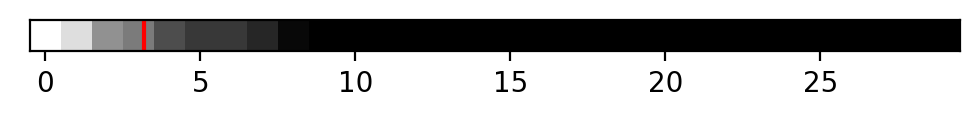

In [ ]:
fig,ax = plt.subplots(dpi=200)
ax.get_yaxis().set_ticks([])
plt.vlines(mean_length_evolution[-1], -1, 1, colors='red')
avg_pos = (res==0).mean(axis=0)
plt.imshow([avg_pos],cmap='gray')

plt.savefig('avg_position_informative_symbol.png')

In [1]:
import numpy as np
np.load('dir_save/messages/messages_300.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'dir_save/messages/messages_300.npy'

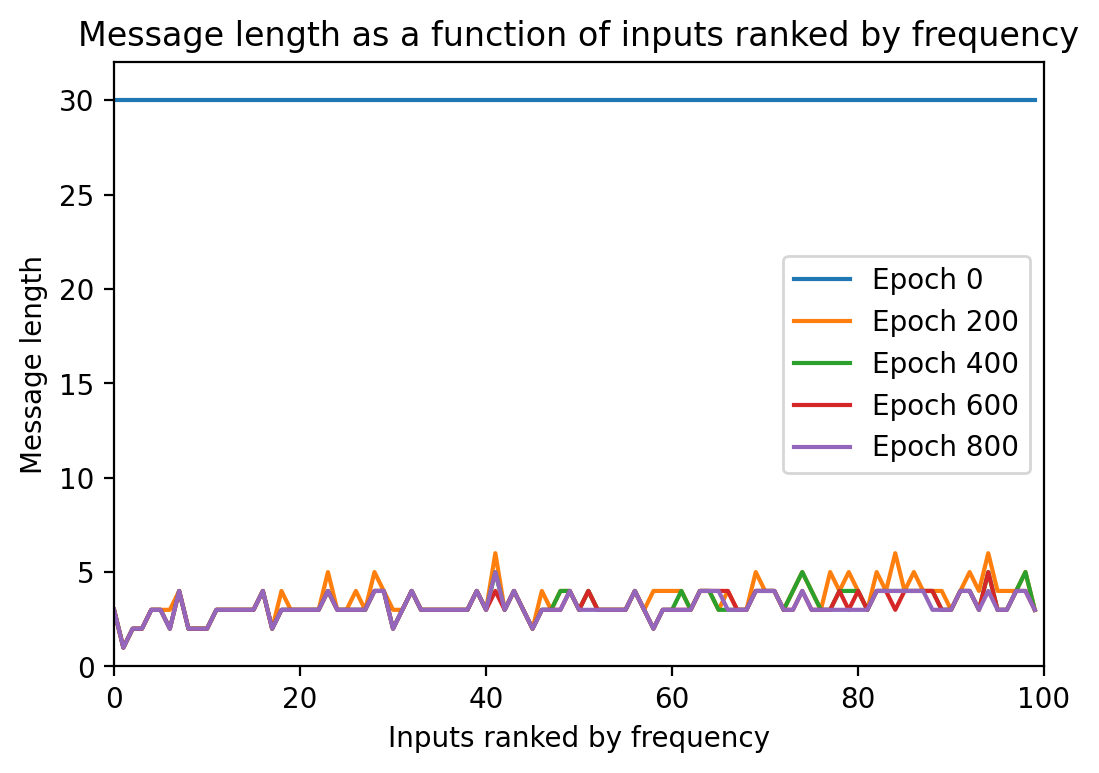

In [ ]:
def load_message(expe):
  """
  Load messages stored during training procedure/
  Return numpy array with all the messages
  """
  np_load_old = np.load
  messages = np.load(expe,allow_pickle=True)
  np.load = np_load_old
  return messages

# Choose epochs (between 0 and 500)
epochs=[0,200,400,600,800]
plt.figure(dpi=200)


for epoch in epochs:
  # Load messages
  messages=load_message("dir_save/messages/messages_"+str(epoch)+".npy")

  # Construct the length distribution
  length_distribution=[]
  for message in messages:
    length_distribution.append(len(message))

  # Add epoch to plot
  plt.plot(length_distribution,label="Epoch "+str(epoch))

# Plot fig
plt.title("Message length as a function of inputs ranked by frequency")
plt.xlabel("Inputs ranked by frequency")
plt.ylabel("Message length")
plt.xlim((0,100))
plt.ylim((0,32))
plt.legend()
plt.savefig('message_length_by_frequency.png')

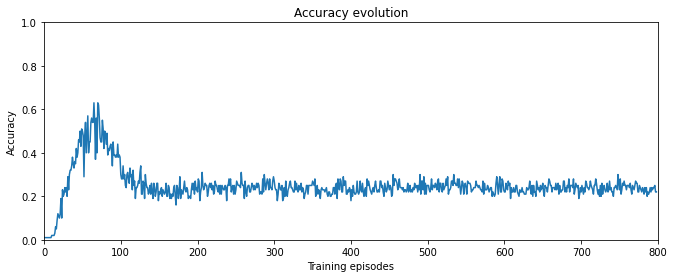

In [ ]:
# Get accuracy
accuracy=[]
for i in range(1,800):
  accuracy.append(np.mean(np.load("dir_save/accuracy/accuracy_"+str(i)+".npy")))

# Plot fig
fig, ax = plt.subplots(1, 1, figsize=(11,4))
ax.plot(accuracy,label="LazImpa",c="tab:blue")
ax.set_title("Accuracy evolution")
ax.set_xlabel("Training episodes")
ax.set_ylabel("Accuracy")
ax.set_xlim((0,800))
ax.set_ylim((0,1))
fig.savefig('acc_evol.png')
plt.show()


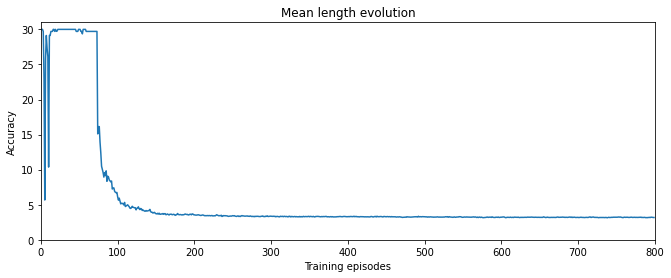

In [ ]:
mean_length_evolution=[]

for epoch in range(800):
  # Load messages
  messages=load_message("dir_save/messages/messages_"+str(epoch)+".npy")

  # Construct the length distribution
  length_distribution=[]
  for message in messages:
    length_distribution.append(len(message))
  
  # Get the mean length
  mean_length_evolution.append(np.mean(length_distribution))

# Plot fig
fig, ax = plt.subplots(1, 1, figsize=(11,4))
ax.plot(mean_length_evolution,label="LazImpa",c="tab:blue")
ax.set_title("Mean length evolution")
ax.set_xlabel("Training episodes")
ax.set_ylabel("Accuracy")
ax.set_xlim((0,800))
ax.set_ylim((0,31))
fig.savefig('length_evol.png')
plt.show()


In [ ]:
mean_length_evolution[-1]

3.78